In [2]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", 
            "dst_bytes", "land", "wrong_fragment","urgent", "hot", "num_failed_logins", 
            "logged_in", "num_compromised", "root_shell", "su_attempted","num_root", 
            "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", 
            "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
            "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
            "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
            "dst_host_serror_rate","dst_host_srv_serror_rate",
            "dst_host_rerror_rate","dst_host_srv_rerror_rate", "label", "N/A"]
print(len(features))

43


Liste des features :                               0
0                      duration
1                 protocol_type
2                       service
3                          flag
4                     src_bytes
5                     dst_bytes
6                          land
7                wrong_fragment
8                        urgent
9                           hot
10            num_failed_logins
11                    logged_in
12              num_compromised
13                   root_shell
14                 su_attempted
15                     num_root
16           num_file_creations
17                   num_shells
18             num_access_files
19            num_outbound_cmds
20                is_host_login
21               is_guest_login
22                        count
23                    srv_count
24                  serror_rate
25              srv_serror_rate
26                  rerror_rate
27              srv_rerror_rate
28                same_srv_rate
29                d

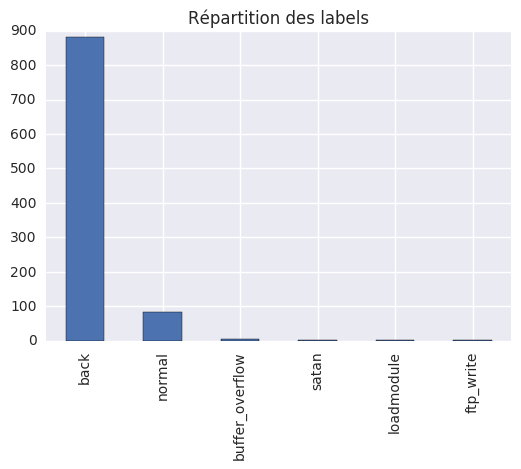

In [66]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

path = "KDDTrain+.txt" ## REPLACE BY DATASET PATH
data = pd.read_csv(path, sep=",", header=None)
labels = data[41]
labels.name = 42

# Sélection des exemples avec connexion réussie
data = data.loc[data[12] == 1]

data.columns = features

# Sélection des exemples concernant TCP
data = data.loc[data["protocol_type"]=="tcp"]

print('Liste des features :', pd.DataFrame(data.columns.values),'\n')
## 'duration' a été retiré des relevant_features
relevant_features = ['src_bytes', 'dst_bytes', 'service', "label"]
data = data[relevant_features]

service_dummies = pd.get_dummies(data['service'])

data.drop('service',axis=1, inplace=True)
data = pd.concat([data, service_dummies], axis=1)
data.drop('login', axis=1, inplace=True)

## Stockage des labels après la création de la dummy de "service" pour les replacer après la normalisation
selected_feat = ['src_bytes', 'dst_bytes', 'auth', 'http', 'pop_3',
       'smtp', 'telnet']

print("5 premiers exemples:\n\n",data[0:5], "\n")
data.label.value_counts().plot(kind='bar', title='Répartition des labels')

In [67]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Imputer

data.loc[data['label'] == "normal", "attack"] = 1  
data.loc[data['label'] != "normal", "attack"] = -1

target = data['attack']
outliers = target[target == -1]
proportion = pd.concat([target, outliers], axis=1)
print("outliers.shape", outliers.shape)
print("target.shape", target.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])
data.drop(["label", "attack"], axis=1, inplace=True)

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(data)
data = imp.transform(data)

data = normalize(data)

outliers.shape (892,)
target.shape (976,)
outlier fraction 0.9139344262295082


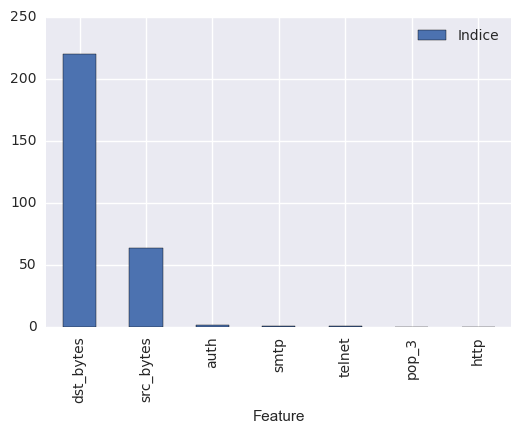

In [70]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np


# Sélection des features
test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(data, target)

scores = pd.DataFrame(fit.scores_)

bestK = pd.DataFrame(fit.get_support(indices=True), index=range(7), columns=[1])
bestK.add(1, axis='columns')

df = pd.concat([scores,bestK], axis=1)
final = df.sort_values(0, axis=0, ascending=False)

ranking = []
for e in final[1]:
    ranking.append((selected_feat[e], final[0][e]))
    
ranking = pd.DataFrame(ranking, columns=['Feature', 'Indice'])
ranking.plot(kind="bar", x='Feature')

In [71]:
from sklearn.cross_validation import train_test_split 
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape 

(780, 7)

In [72]:
from sklearn import svm

model = svm.SVC(C=8.0, gamma=0.03125, kernel='rbf',class_weight={1:10})  
model.fit(data,target)

SVC(C=8.0, cache_size=200, class_weight={1: 10}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.03125, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
from sklearn import metrics  

preds = model.predict(train_data)  
targs = train_target

resultats = {'accuracy': metrics.accuracy_score(targs, preds),
            "precision: ": metrics.precision_score(targs, preds),
            "recall: ": metrics.recall_score(targs, preds),
            "f1: ": metrics.f1_score(targs, preds)}

df_resultats = pd.DataFrame.from_dict(resultats, orient='index')
df_resultats.columns = ['']

df_resultats

,
accuracy,0.989744
precision:,0.901408
f1:,0.941176
recall:,0.984615


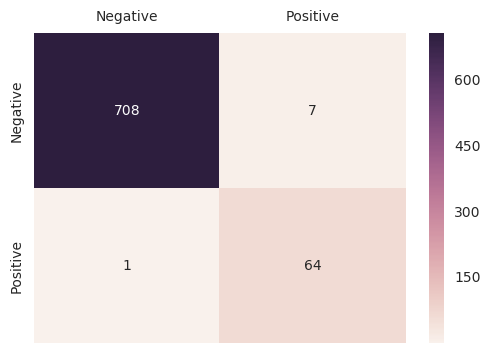

In [74]:
import seaborn as sn

tn, fp, fn, tp = metrics.confusion_matrix(targs, preds).ravel()

conf_values = [[tn], [fp], [fn], [tp]]
conf_matrix = pd.DataFrame(np.array(conf_values).reshape(2,2))
conf_matrix.columns = ['Negative', 'Positive']


plot = sn.heatmap(conf_matrix, annot=True, fmt="d", yticklabels=['Negative', 'Positive'])
plot.xaxis.tick_top()

In [76]:
## Export du modele en fichier pkl pour l'intégrer à la prochaine étape du dev (probe)
import os
from sklearn.externals import joblib


# Nettoyage du dossier s'il existe déjà, sinon création du dossier
if os.path.exists('Light_TCP_clf') == True:
    for e in os.listdir('Light_TCP_clf'):
        os.remove('Light_TCP_clf/'+e)
else:
    os.mkdir('Light_TCP_clf')

    
joblib.dump(model, 'Light_TCP_clf/Light_TCP_clf.pkl')

['Light_TCP_clf/Light_TCP_clf.pkl',
 'Light_TCP_clf/Light_TCP_clf.pkl_01.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_02.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_03.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_04.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_05.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_06.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_07.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_08.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_09.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_10.npy',
 'Light_TCP_clf/Light_TCP_clf.pkl_11.npy']